In [1]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python3 --version
import metnum


/home/dago/Desktop/Facultad/MN/MNTp3bis/MNTp3/tp3/notebooks
Python 3.7.6


# K-Fold


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

def K_Fold(X, y, K=10):
    
    kfold = KFold(n_splits=K)
    #kfold.get_n_splits(X)
    rmse = []
    rmsle = []
    deleted = []
    for train_index, test_index in kfold.split(X):
        # Separamos el conjunto de entrenamiento y el conjunto de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        linear_regressor = metnum.LinearRegression()
        linear_regressor.fit(X_train, y_train) 
        y_pred = linear_regressor.predict(X_test)
        data = {"y_pred": y_pred.T[0], "y_test": y_test.T[0]}
        df_temp = pd.DataFrame(data)
            
        deleted.append(100 * (y_pred < 0).sum() / len(y_pred))
        df_temp2 = df_temp[df_temp["y_pred"]>=0]
        y_test = df_temp2["y_test"].values
        y_pred = df_temp2["y_pred"].values
        rmsle.append(mean_squared_log_error(y_test, y_pred))
        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
    return np.mean(rmse), np.mean(rmsle), np.mean(deleted), np.max(deleted)

# Data and plots

In [3]:
def fecha_parser(df):
    df['fecha'] = (pd.to_datetime(df['fecha']) - pd.to_datetime(df['fecha'].min())).dt.days

def complete_metrostotales(df):
    df['metrostotales'] = df['metrostotales'].fillna(df['metroscubiertos'])
    
def fill_banosterrenos(df):
    df['banos'] = df.apply(
        lambda row: 0 if row['tipodepropiedad']=='Terreno' and np.isnan(row['banos']) else row['banos'],
        axis=1
    )
    df['banos'] = df.apply(
        lambda row: 0 if row['tipodepropiedad']=='Terreno comercial' and np.isnan(row['banos']) else row['banos'],
        axis=1
    )

def poblacion():
    df = pd.read_csv('../data/poblacion.csv', names=['poblacion', 'ciudad'])
    return df
    
def get_data(filename='../data/train.csv'):
    df = pd.read_csv(filename)
    fecha_parser(df)
    complete_metrostotales(df)
    fill_banosterrenos(df)
    df = df[(df['lat'] > 13) & (df['lat'] < 34) & (df['lng'] >= -117) & (df['lng'] <= -87)]
    dfPob = poblacion()
    dfJoin = pd.merge(df, dfPob, how='left')
    return dfJoin

In [81]:

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

translation = {"escuelascercanas": 'esc',
               "usosmultiples": 'sum',
               "centroscomercialescercanos": 'ccc',
               "gimnasio": 'gym'
               }
            
def plot_bubble(df, title=''):
    df['name'] = df.apply(
        lambda row:
        translation[row['name']] if row['name'] in translation.keys() else row['name'],
        axis=1
    )
    bubble_chart = BubbleChart(area=(df['value']),
                               bubble_spacing=0.1)

    bubble_chart.collapse()

    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
    bubble_chart.plot(
        ax, df['name'], df['color'])
    ax.axis("off")
    ax.relim()
    ax.autoscale_view()
    ax.set_title(f'Peso de cada feature en la predicción{title}')

    plt.show()

In [58]:
def plot_prediction(df, columns, column_to_show='precio', column_to_predict='metroscubiertos', kfold_flag=True, title=''):
    df = df.reindex(columns=(columns+[column_to_predict])).dropna()
    y = df[column_to_predict].values
    df = df.drop(columns=[column_to_predict])
    X = df.to_numpy()
    print('Size: ', X.shape[0])
    #from sklearn.linear_model import LinearRegression
    

    col_avg=np.array(df.mean())


    #linear_regressor = LinearRegression()
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(X,y)

    df['prediccion'] = linear_regressor.predict(X)
    # print(df[df['prediccion']<0])
    coef = linear_regressor.coef()
    
    print(list(zip(df.columns, coef.T[0], coef.T[0] * col_avg)))
    
    data = { "name": columns, "value": coef.T[0] * col_avg }
    dfForBubble = pd.DataFrame(data)
    print(dfForBubble)
    dfForBubble['color'] = dfForBubble.apply(
        lambda row: '#9CE699' if row['value'] >= 0 else '#DD6E77',
        axis=1
    )
    dfForBubble['value'] = np.abs(dfForBubble['value'])
    plot_bubble(dfForBubble, title)

    print((df['prediccion'] < 0).any())
    
    sns.scatterplot(x=df[column_to_show], y=y).set_title(f"{column_to_predict} en función de {column_to_show}{title}")
    sns.lineplot(data=df, x=column_to_show, y='prediccion', color='red', label=f'predicción de {column_to_predict}')
    
    if (kfold_flag):
        X = X.reshape(len(X),len(columns))
        y = y.reshape(len(y),1)

        rmse, rmsle, avg_deleted, max_deleted = K_Fold(X, y, 10) # 10% de las muestras para testear
        print(rmse, '  ', rmsle, '  ', avg_deleted,"%", '  ', max_deleted )

In [78]:
def plot_prediction_colorful(df, columns, column_to_show='precio', column_to_predict='metroscubiertos', kfold_flag=True, title=''):
    df = df.reindex(columns=(columns+[column_to_predict]+['tipodepropiedad'])).dropna()
    print(df['tipodepropiedad'].value_counts())
    y = df[column_to_predict].values
    df2 = df
    df = df.drop(columns=[column_to_predict, 'tipodepropiedad'])
    X = df.to_numpy()
    print('Size: ', X.shape[0])
    #from sklearn.linear_model import LinearRegression
    
    col_avg=np.array(df.mean())
    #linear_regressor = LinearRegression()
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(X,y)
    
    df['prediction'] = linear_regressor.predict(X)
    
    coef = linear_regressor.coef()

    
    print(list(zip(df.columns, coef.T[0], coef.T[0] * col_avg)))
    
    data = { "name": columns, "value": coef.T[0] * col_avg }
    dfForBubble = pd.DataFrame(data)
    print(dfForBubble)
    dfForBubble['color'] = dfForBubble.apply(
        lambda row: '#9CE699' if row['value'] >= 0 else '#DD6E77',
        axis=1
    )
    dfForBubble['value'] = np.abs(dfForBubble['value'])
    plot_bubble(dfForBubble, title)

    print((df['prediction'] < 0).any())
    
    sns.scatterplot(x=df[column_to_show], y=y, hue=df2["tipodepropiedad"], alpha=0.5).set_title(f"{column_to_predict} en función de {column_to_show}{title}")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    #sns.lineplot(data=df, x=column_to_show, y='prediction', color='red', label=f'predicción de {column_to_predict}')
    
    if (kfold_flag):
        X = X.reshape(len(X),len(columns))
        y = y.reshape(len(y),1)

        rmse, rmsle, avg_deleted, max_deleted = K_Fold(X, y, 10) # 10% de las muestras para testear
        print(rmse, '  ', rmsle, '  ', avg_deleted,"%", '  ', max_deleted )

# Prediccion de metros cubiertos

## Aproximacion lineal para ver que valores obtiene de error agregando una feature por vez en orden de importancia segun sentido comun

In [ ]:
df = get_data()

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
posx and posy should be finite values
posx and posy should be finite values


Size:  108263
[('precio', 5.2062739193877235e-05, 130.55921229683366)]
     name       value
0  precio  130.559212


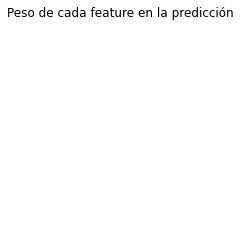

False
99.47386099663166    0.5135870741264139    0.0 %    0.0


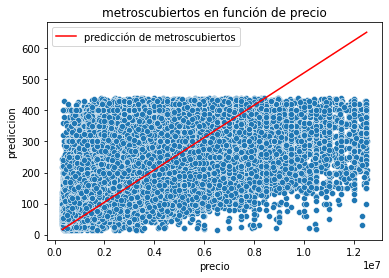

In [9]:
columns=["precio"]
plot_prediction(df, columns,  kfold_flag=True)

Size:  101985
[('precio', 2.4821019876169397e-05, 61.864619664283666), ('habitaciones', 38.14335437309643, 109.91876106067)]
           name       value
0        precio   61.864620
1  habitaciones  109.918761


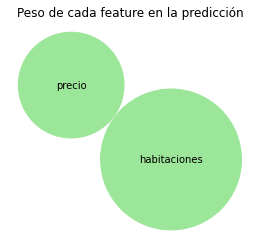

False
64.1291278359301    0.14334392641683302    0.0 %    0.0


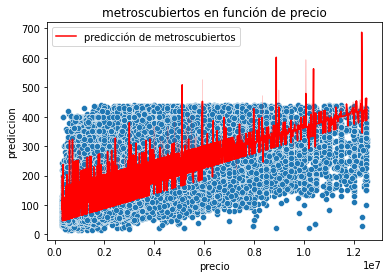

In [12]:
columns=["precio", "habitaciones"]
plot_prediction(df, columns,  kfold_flag=True)

Size:  99008
[('precio', 1.7701418547440676e-05, 43.30120513623143), ('habitaciones', 19.81634417526898, 56.434389507385184), ('banos', 33.35589145161413, 69.85271066667565)]
           name      value
0        precio  43.301205
1  habitaciones  56.434390
2         banos  69.852711


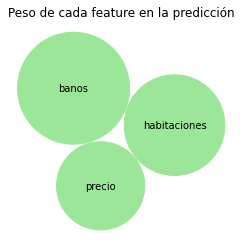

False
58.7200127968836    0.12495063835702853    0.0 %    0.0


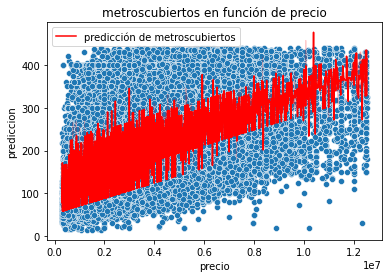

In [13]:
columns=["precio", "habitaciones", "banos"]
plot_prediction(df, columns,  kfold_flag=True)

Size:  85028
[('precio', 1.8158467839258122e-05, 43.866184562921994), ('habitaciones', 17.528656680540088, 50.10864648549698), ('banos', 34.45696830143194, 71.26677517319499), ('antiguedad', 0.42657044564802704, 3.834232574535987)]
           name      value
0        precio  43.866185
1  habitaciones  50.108646
2         banos  71.266775
3    antiguedad   3.834233


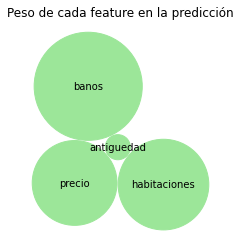

False
57.96079980232942    0.12314988647356787    0.0 %    0.0


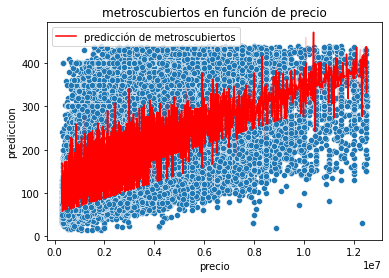

In [8]:
columns=["precio", "habitaciones", "banos","antiguedad"]
plot_prediction(df, columns,  kfold_flag=True)

Size:  75083
[('precio', 1.5985264157528574e-05, 36.04489144852638), ('habitaciones', 15.019773020416235, 42.29913595540979), ('banos', 31.209057387107237, 62.69245088059662), ('antiguedad', 0.4610913244142452, 4.077154423200448), ('garages', 8.96576797001124, 14.625750069961466)]
           name      value
0        precio  36.044891
1  habitaciones  42.299136
2         banos  62.692451
3    antiguedad   4.077154
4       garages  14.625750


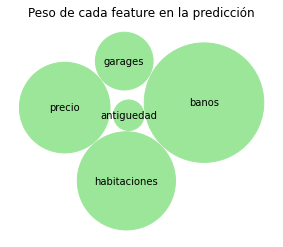

False
55.02636427678451    0.12004932564455646    0.0 %    0.0


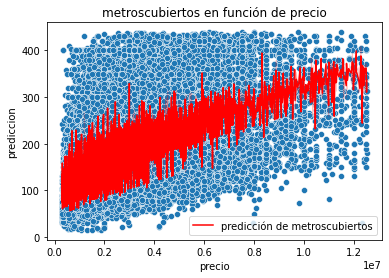

In [15]:
columns=["precio", "habitaciones", "banos","antiguedad", "garages"]
plot_prediction(df, columns,  kfold_flag=True)

Size:  75083
[('precio', 1.5885266013661526e-05, 35.81940738988201), ('habitaciones', 16.47636029678495, 46.40122079719077), ('banos', 31.2750007848391, 62.82491733646953), ('antiguedad', 0.48520769840638794, 4.290401074541223), ('garages', 10.124766067028187, 16.5164098054386), ('escuelascercanas', -10.694021531818585, -6.515572220004168)]
               name      value
0            precio  35.819407
1      habitaciones  46.401221
2             banos  62.824917
3        antiguedad   4.290401
4           garages  16.516410
5  escuelascercanas  -6.515572


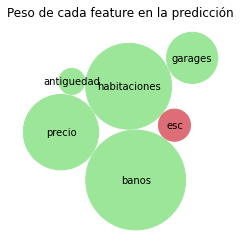

False
54.75790603502536    0.11698408542521914    0.0 %    0.0


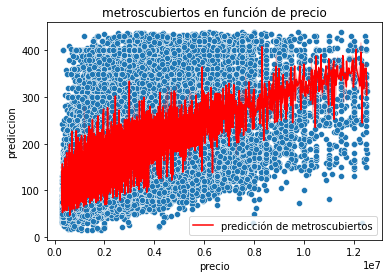

In [82]:
columns=["precio", "habitaciones", "banos","antiguedad", "garages", "escuelascercanas"]
plot_prediction(df, columns,  kfold_flag=True)

Size:  75083
[('precio', 1.5488374607279548e-05, 34.9244639270207), ('habitaciones', 27.389517196412605, 77.13518107559156), ('banos', 33.352063474544686, 66.99730066208964), ('antiguedad', 0.729728806293285, 6.452554782059854), ('garages', 15.259152169926976, 24.892072454177324), ('escuelascercanas', -3.061766385658243, -1.8654497699655312), ('C', -52.394759573310715, -52.394759573310715)]
               name      value
0            precio  34.924464
1      habitaciones  77.135181
2             banos  66.997301
3        antiguedad   6.452555
4           garages  24.892072
5  escuelascercanas  -1.865450
6                 C -52.394760


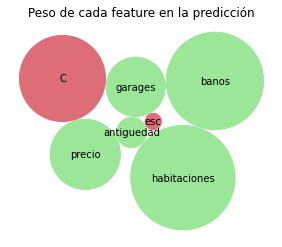

True
53.209241738069025    0.10460091237763643    0.0013317352510320948 %    0.013317352510320948


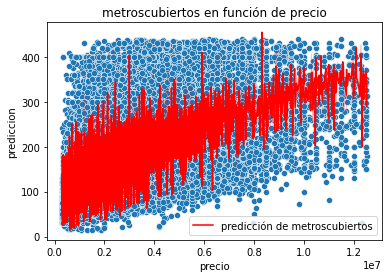

In [83]:
df['C'] = np.ones(len(df))
columns=["precio", "habitaciones", "banos","antiguedad", "garages", "escuelascercanas", "C"]
plot_prediction(df, columns,  kfold_flag=True)

Size:  75083
[('precio', 1.5488374607279548e-05, 34.9244639270207), ('habitaciones', 27.389517196412605, 77.13518107559156), ('banos', 33.352063474544686, 66.99730066208964), ('antiguedad', 0.729728806293285, 6.452554782059854), ('garages', 15.259152169926976, 24.892072454177324), ('escuelascercanas', -3.061766385658243, -1.8654497699655312), ('C', -52.394759573310715, -52.394759573310715)]
               name      value
0            precio  34.924464
1      habitaciones  77.135181
2             banos  66.997301
3        antiguedad   6.452555
4           garages  24.892072
5  escuelascercanas  -1.865450
6                 C -52.394760


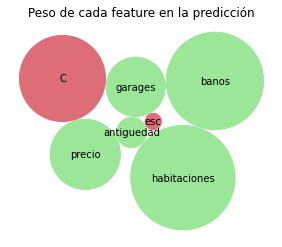

True
53.209241738069025    0.10460091237763643    0.0013317352510320948 %    0.013317352510320948


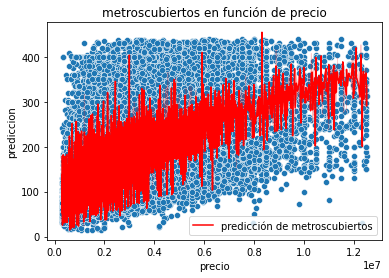

In [84]:
df['C'] = np.ones(len(df))
columns=["precio", "habitaciones", "banos","antiguedad", "garages", "escuelascercanas", "C"]
plot_prediction(df, columns,  kfold_flag=True)

# Chequeando por tipo de propiedad

Casa                             44011
Apartamento                      23631
Casa en condominio                6575
Duplex                             147
Casa uso de suelo                  138
Oficina comercial                  108
Local Comercial                    100
Villa                               63
Departamento Compartido             57
Edificio                            45
Bodega comercial                    45
Quinta Vacacional                   39
Inmuebles productivos urbanos       27
Terreno                             24
Rancho                              21
Terreno comercial                   21
Otros                               20
Nave industrial                      5
Terreno industrial                   2
Local en centro comercial            2
Name: tipodepropiedad, dtype: int64
Size:  75081
[('precio', 1.548829001191883e-05, 34.92494465853962), ('habitaciones', 27.390253835004803, 77.1374863466979), ('banos', 33.351052681922646, 66.99616640292885), ('antigued

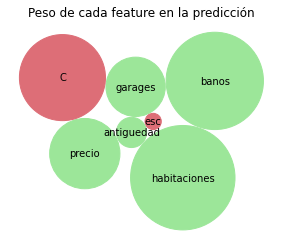

True
53.20977455973804    0.10460213093658854    0.0013317352510320948 %    0.013317352510320948


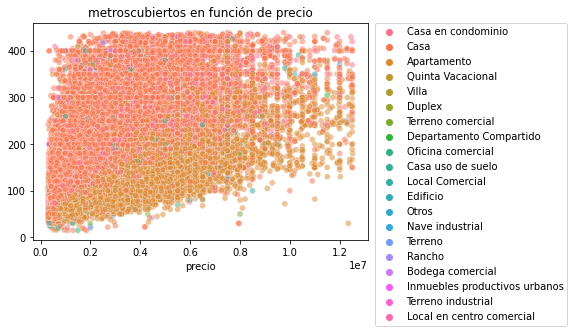

In [85]:
columns=["precio", "habitaciones", "banos","antiguedad", "garages", "escuelascercanas", "C"]
plot_prediction_colorful(df, columns)

Size:  75083
[('precio', 1.6218809445924946e-05, 36.571508618290025), ('habitaciones', 26.7506883603923, 75.33609211796694), ('banos', 33.437684495585984, 67.16929533624457), ('antiguedad', 0.6566996822758729, 5.806801977258553), ('garages', 15.326550034394046, 25.002017784487187), ('escuelascercanas', -1.6163647305582434, -0.9848064270756016), ('C', -51.1795002337393, -51.1795002337393), ('gimnasio', -20.72219475437977, -1.5800456157695377)]
               name      value
0            precio  36.571509
1      habitaciones  75.336092
2             banos  67.169295
3        antiguedad   5.806802
4           garages  25.002018
5  escuelascercanas  -0.984806
6                 C -51.179500
7          gimnasio  -1.580046


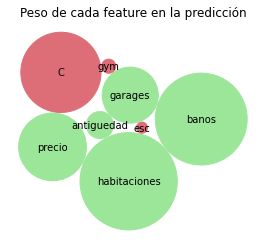

True
52.95382679673442    0.10428729054153427    0.0013317352510320948 %    0.013317352510320948


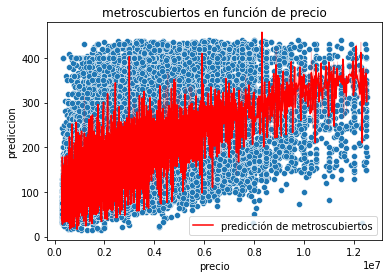

In [86]:
columns=["precio", "habitaciones", "banos","antiguedad", "garages", "escuelascercanas", "C", "gimnasio"]
plot_prediction(df, columns)

Size:  75083
[('habitaciones', 26.671811035993212, 75.11395542761744), ('banos', 33.55874922395507, 67.41248898488668), ('precio', 1.6281696745582543e-05, 36.713312085990715), ('C', -51.22579674103931, -51.22579674103931), ('garages', 15.404917221766198, 25.129857240072553), ('gimnasio', -17.495943907470007, -1.334047372511298), ('escuelascercanas', -1.233098861096567, -0.7512931089557363), ('antiguedad', 0.6432035330122071, 5.687463612485736), ('usosmultiples', -7.624021275055476, -0.6045765708839591)]
               name      value
0      habitaciones  75.113955
1             banos  67.412489
2            precio  36.713312
3                 C -51.225797
4           garages  25.129857
5          gimnasio  -1.334047
6  escuelascercanas  -0.751293
7        antiguedad   5.687464
8     usosmultiples  -0.604577


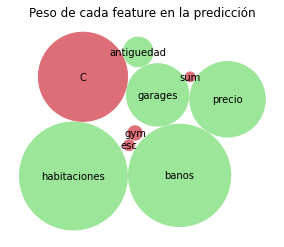

True
52.924438852301606    0.1040659348536727    0.0013317352510320948 %    0.013317352510320948


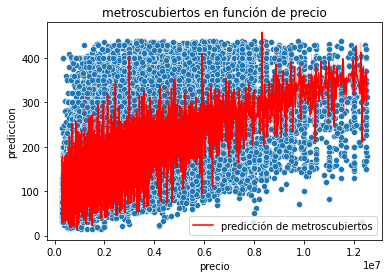

In [87]:
columns=["habitaciones", "banos", "precio", "C", "garages", "gimnasio" ,"escuelascercanas", "antiguedad", "usosmultiples" ]
plot_prediction(df, columns)

Size:  75083
[('habitaciones', 26.64659904435707, 75.04295265943485), ('banos', 33.62245060650928, 67.54045170248084), ('precio', 1.6289922417083883e-05, 36.731860008216785), ('C', -51.18769774112496, -51.18769774112496), ('garages', 15.410726710591305, 25.139334189718635), ('gimnasio', -16.864896418309147, -1.2859306633301795), ('escuelascercanas', -1.182519237700635, -0.7204763401549386), ('antiguedad', 0.6385627994368096, 5.646428384924551), ('usosmultiples', -7.1942268722098905, -0.5704943435549683), ('piscina', -1.8581594465738016, -0.19506429894776053)]
               name      value
0      habitaciones  75.042953
1             banos  67.540452
2            precio  36.731860
3                 C -51.187698
4           garages  25.139334
5          gimnasio  -1.285931
6  escuelascercanas  -0.720476
7        antiguedad   5.646428
8     usosmultiples  -0.570494
9           piscina  -0.195064


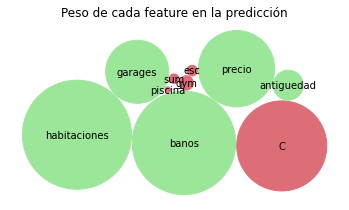

True
52.92322893695592    0.10403243673939369    0.0013317352510320948 %    0.013317352510320948


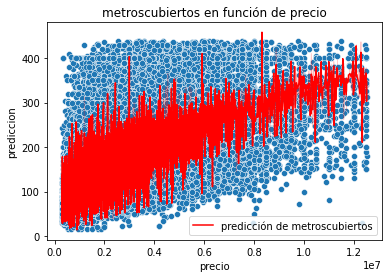

In [88]:
columns=["habitaciones", "banos", "precio", "C", "garages", "gimnasio" ,"escuelascercanas", "antiguedad", "usosmultiples", "piscina" ]
plot_prediction(df, columns)

Size:  75083
[('habitaciones', 26.608763942977337, 74.93640031040982), ('banos', 33.44516114304504, 67.18431435292824), ('precio', 1.6412490746978575e-05, 37.008237183003764), ('C', -49.89601747394358, -49.89601747394358), ('garages', 15.378905726339159, 25.0874249986478), ('gimnasio', -17.171616473805653, -1.3093177458617447), ('escuelascercanas', 6.449573034701503, 3.929546875397293), ('antiguedad', 0.6349974460309006, 5.614902100131313), ('usosmultiples', -5.97463453665881, -0.47378200166837436), ('piscina', -1.1787801621915477, -0.1237449920540439), ('centroscomercialescercanos', -10.237646956179644, -5.8166000493276435)]
                          name      value
0                 habitaciones  74.936400
1                        banos  67.184314
2                       precio  37.008237
3                            C -49.896017
4                      garages  25.087425
5                     gimnasio  -1.309318
6             escuelascercanas   3.929547
7                   antiguedad

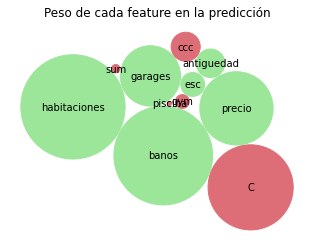

True
52.817841861718264    0.1039357893355316    0.0013317352510320948 %    0.013317352510320948


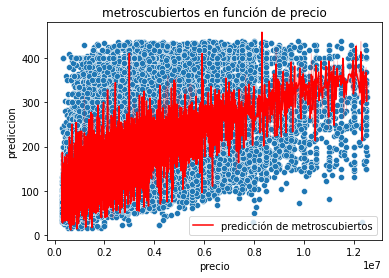

In [89]:
columns=["habitaciones", "banos", "precio", "C", "garages", "gimnasio" ,"escuelascercanas", "antiguedad", "usosmultiples", "piscina", "centroscomercialescercanos" ]
plot_prediction(df, columns)

Size:  75083
[('habitaciones', 26.68647880613492, 75.15526324249211), ('banos', 33.299267649986916, 66.89124492331055), ('precio', 1.6362248678345094e-05, 36.89494722468986), ('C', -49.820601897281016, -49.820601897281016), ('garages', 15.310265765886369, 24.975453452010367), ('gimnasio', -20.19152570237805, -1.5395826571409552), ('escuelascercanas', 6.470293978963287, 3.942171574945787), ('antiguedad', 0.6486345866883918, 5.735487167356618), ('centroscomercialescercanos', -10.724165617343854, -6.093019472720475)]
                         name      value
0                habitaciones  75.155263
1                       banos  66.891245
2                      precio  36.894947
3                           C -49.820602
4                     garages  24.975453
5                    gimnasio  -1.539583
6            escuelascercanas   3.942172
7                  antiguedad   5.735487
8  centroscomercialescercanos  -6.093019


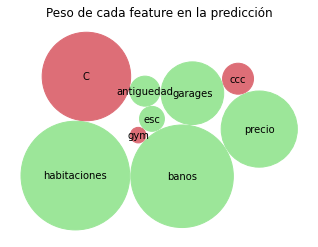

True
52.8368388736644    0.10410537596481875    0.0013317352510320948 %    0.013317352510320948


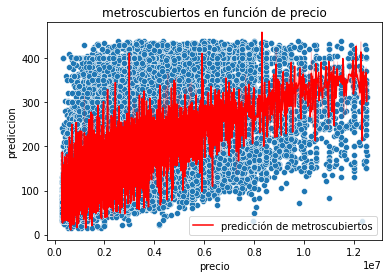

In [90]:
columns=["habitaciones", "banos", "precio", "C", "garages", "gimnasio" ,"escuelascercanas", "antiguedad", "centroscomercialescercanos" ]
plot_prediction(df, columns)

In [65]:
dfCasa = df[df['tipodepropiedad'] == 'Casa']
len(dfCasa)

66241

In [67]:
dfDepartamento = df[df['tipodepropiedad'] == 'Apartamento']
len(dfDepartamento)

29872

## Casa

Size:  44011
[('habitaciones', 18.858823929710272, 57.24750671844227), ('banos', 28.824457133634375, 60.96879277969503), ('precio', 2.695555786709079e-05, 55.15366299555382), ('C', -10.824372886269122, -10.824372886269122), ('garages', 8.551877948388364, 14.803098449572207), ('escuelascercanas', 3.976600908260835, 2.421325376373494), ('antiguedad', 0.3708193457457484, 3.31052170538396), ('usosmultiples', -1.1648050680951478, -0.05253545841196221), ('piscina', -1.7037992308469148, -0.1163326597599459), ('centroscomercialescercanos', -9.063076581192636, -4.937730346137035), ('gimnasio', -1.0489280404457857, -0.039420303535419095)]
                          name      value
0                 habitaciones  57.247507
1                        banos  60.968793
2                       precio  55.153663
3                            C -10.824373
4                      garages  14.803098
5             escuelascercanas   2.421325
6                   antiguedad   3.310522
7                usosmultip

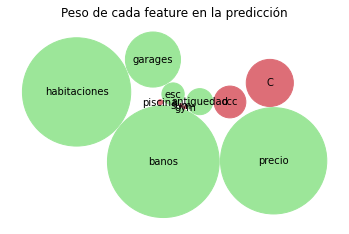

False
52.72809321170276    0.0859661664612834    0.0 %    0.0


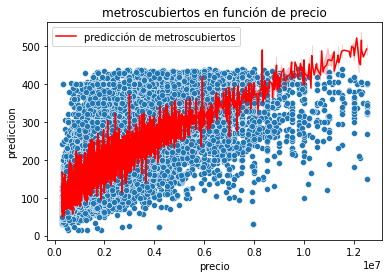

In [97]:
columns=["habitaciones", "banos", "precio", "C", "garages", "escuelascercanas", "antiguedad", "usosmultiples", "piscina", "centroscomercialescercanos","gimnasio" ]
plot_prediction(dfCasa, columns)

Size:  44011
[('habitaciones', 18.880627448266573, 57.3136930872047), ('banos', 28.734093213902195, 60.77765720786552), ('precio', 2.692910546289935e-05, 55.09953883335356), ('C', -10.744803182218767, -10.744803182218767), ('garages', 8.514377276424554, 14.738185673412906), ('escuelascercanas', 3.7996726109059464, 2.3135949336997013), ('antiguedad', 0.3802189078465973, 3.394437107082825), ('centroscomercialescercanos', -9.099890582946156, -4.957787289493147)]
                         name      value
0                habitaciones  57.313693
1                       banos  60.777657
2                      precio  55.099539
3                           C -10.744803
4                     garages  14.738186
5            escuelascercanas   2.313595
6                  antiguedad   3.394437
7  centroscomercialescercanos  -4.957787


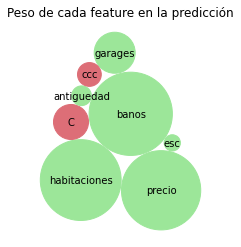

False
52.72814559572241    0.08599773851784391    0.0 %    0.0


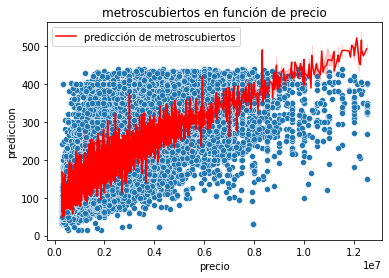

In [92]:
columns=["habitaciones", "banos", "precio", "C", "garages" ,"escuelascercanas", "antiguedad", "centroscomercialescercanos" ]
plot_prediction(dfCasa, columns)

## Departamento

Size:  23631
[('habitaciones', 18.2654531586134, 43.29726309224697), ('banos', 24.192561925444995, 42.15961629434854), ('precio', 1.2859165948356448e-05, 32.747286733382396), ('C', -26.330931456404105, -26.330931456404105), ('garages', 9.198176810943622, 12.63557257995226), ('gimnasio', -2.9706042609294894, -0.4533028210787414), ('escuelascercanas', -0.586908587427514, -0.35553283521750506), ('antiguedad', 0.6411098509594009, 5.848991319799763), ('usosmultiples', -0.6150227846667775, -0.0814877211625272), ('piscina', 13.021315891260612, 1.983696720770945), ('centroscomercialescercanos', -2.8907106617408527, -1.7442614923516913)]
                          name      value
0                 habitaciones  43.297263
1                        banos  42.159616
2                       precio  32.747287
3                            C -26.330931
4                      garages  12.635573
5                     gimnasio  -0.453303
6             escuelascercanas  -0.355533
7                   antigue

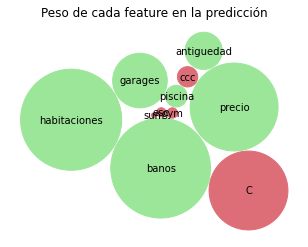

False
32.22529758910009    0.06137307110330596    0.0 %    0.0


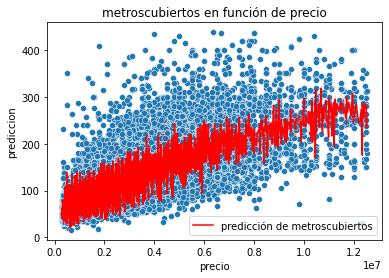

In [93]:
columns=["habitaciones", "banos", "precio", "C", "garages", "gimnasio" ,"escuelascercanas", "antiguedad", "usosmultiples", "piscina", "centroscomercialescercanos" ]
plot_prediction(dfDepartamento, columns)

Size:  23631
[('habitaciones', 18.366297945975916, 43.536310174846044), ('banos', 24.195213726829955, 42.164237505166284), ('precio', 1.276732544319752e-05, 32.513404740704445), ('C', -26.411862612697927, -26.411862612697927), ('garages', 9.073214673923491, 12.463911588375625), ('antiguedad', 0.6483293555157618, 5.9148565056493), ('piscina', 11.338578797963923, 1.7273447451512896), ('centroscomercialescercanos', -3.648133582710326, -2.2012922329087443)]
                         name      value
0                habitaciones  43.536310
1                       banos  42.164238
2                      precio  32.513405
3                           C -26.411863
4                     garages  12.463912
5                  antiguedad   5.914857
6                     piscina   1.727345
7  centroscomercialescercanos  -2.201292


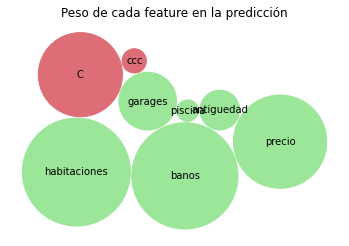

False
32.23303454980278    0.06149662048496409    0.0 %    0.0


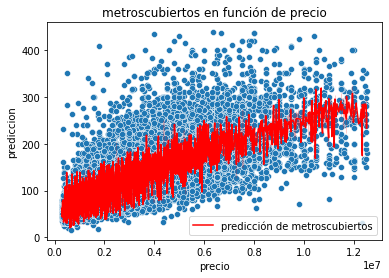

In [94]:
columns=["habitaciones", "banos", "precio", "C", "garages" , "antiguedad", "piscina", "centroscomercialescercanos" ]
plot_prediction(dfDepartamento, columns)

## Agregamos población a los features

Size:  41644
[('habitaciones', 19.266445815859985, 58.747299878583156), ('banos', 28.35427514577475, 60.40841416490797), ('precio', 2.762323297894757e-05, 57.62283018060784), ('C', -9.900463943525327, -9.900463943525327), ('garages', 8.516947329066921, 14.848006341616044), ('antiguedad', 0.48723608573155375, 4.44088711873115), ('piscina', -2.556060724779527, -0.1694669979136556), ('centroscomercialescercanos', -6.116671655910232, -3.3651681949034513), ('poblacion', -1.4603932040624036e-06, -2.8696596507836016)]
                         name      value
0                habitaciones  58.747300
1                       banos  60.408414
2                      precio  57.622830
3                           C  -9.900464
4                     garages  14.848006
5                  antiguedad   4.440887
6                     piscina  -0.169467
7  centroscomercialescercanos  -3.365168
8                   poblacion  -2.869660


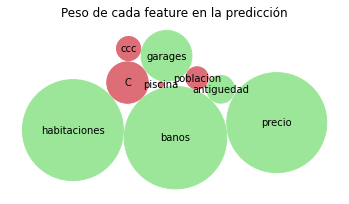

False
52.65207197585414    0.08483724508206511    0.0 %    0.0


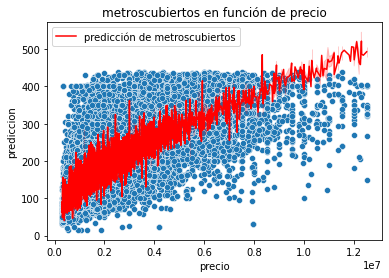

In [95]:
columns=["habitaciones", "banos", "precio", "C", "garages" , "antiguedad", "piscina", "centroscomercialescercanos", "poblacion" ]
plot_prediction(dfCasa, columns)

Size:  23466
[('habitaciones', 16.981561232716842, 40.270600847107595), ('banos', 22.002790971159826, 38.35439208537001), ('precio', 1.4607698098022358e-05, 37.27514253950555), ('C', -3.967096294271565, -3.967096294271565), ('garages', 6.948471456440281, 9.55392617156932), ('antiguedad', 0.7527972142871803, 6.884119756834826), ('piscina', 1.578694181013681, 0.2382909225752347), ('centroscomercialescercanos', -2.8251558684545297, -1.7074218241891308), ('poblacion', -2.6568319648369143e-06, -17.130028865713815)]
                         name      value
0                habitaciones  40.270601
1                       banos  38.354392
2                      precio  37.275143
3                           C  -3.967096
4                     garages   9.553926
5                  antiguedad   6.884120
6                     piscina   0.238291
7  centroscomercialescercanos  -1.707422
8                   poblacion -17.130029


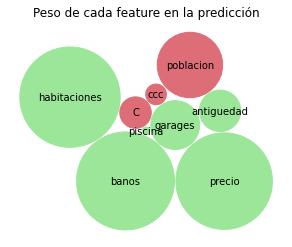

False
30.78761686927836    0.05924322607206162    0.0 %    0.0


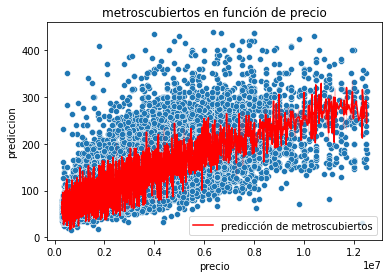

In [96]:
columns=["habitaciones", "banos", "precio", "C", "garages" , "antiguedad", "piscina", "centroscomercialescercanos", "poblacion" ]
plot_prediction(dfDepartamento, columns)